<h1> 2D QPI </h1>

In [1]:
import os
import torch
import tifffile
import numpy as np
from torchvision import models, transforms

# Load the pretrained model
checkpoint = r"C:\rkka_Projects\cell_death_v1\finetuning\assay\2d_qpi\qpi_model_epoch_18_val_acc_100.00.pth"

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=2)  # Binary classification
model.load_state_dict(torch.load(checkpoint))
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Device is {device}")

# Define normalization parameters
mean = [0.1928, 0.1928, 0.1928]
std = [0.1029, 0.1029, 0.1029]

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((214, 214)),
    transforms.Normalize(mean=mean, std=std)
])

# Path to timelapse data folder
root_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\timelapse\qpi\cropped"

# Store probabilities for all files
all_probabilities = {}

# Process each file in the root folder
for filename in os.listdir(root_dir):
    file_path = os.path.join(root_dir, filename)
    if not file_path.endswith(('.tif', '.tiff')):
        continue

    print(f"Processing file: {filename}")
    timelapse_image = tifffile.imread(file_path)
    timelapse_tensor = torch.zeros((timelapse_image.shape[0], 3, 214, 214))

    for i, frame in enumerate(timelapse_image):
        # Normalize and make 3 channels image: (3, H, W)
        frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
        frame = np.stack([frame] * 3, axis=0)  # Convert to 3 channels
        frame = torch.from_numpy(frame)
        frame = frame.unsqueeze(0)  # Add batch dimension
        frame = transform(frame)
        timelapse_tensor[i] = frame

    # Predict probabilities for the timelapse
    dead_probabilities = []
    with torch.no_grad():
        for frame in timelapse_tensor:
            frame = frame.unsqueeze(0).to(device)  # Add batch dimension
            outputs = model(frame)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            dead_prob = probabilities[0, 0].item()  # Probability for the "dead" class
            dead_probabilities.append(dead_prob)

    # Store probabilities for this file
    all_probabilities[filename] = dead_probabilities

print("All probabilities have been computed.")


C:\Users\김민욱\AppData\Local\Temp\ipykernel_4132\1326612484.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


Device is cuda
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P25.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P02.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P10.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P19.tif
Processing file: qpi_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P20.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P12.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P19.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P20.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P26.tif
Processing file: qpi_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P28.tif
Processing file: qpi_230512.160429.

In [4]:
import napari
viewer = napari.Viewer()

In [5]:
from TCFile import TCFile
file = TCFile(r"C:\rkka_Projects\cell_death_v1\Data\before_preprocess\Hela_PWS\Hela_Segmentation_test_PWS\TCF\230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17.TCF", '3D')
viewer.add_image(file[0])

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"


<Image layer 'Image' at 0x2b11611e2a0>

In [2]:
import json

with open('all_probabilities.json', 'r') as f:
    all_probabilities = json.load(f)

In [46]:
all_probabilities['qpi_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17.tif'][14]

0.30873122811317444

C:\Users\김민욱\AppData\Local\Temp\ipykernel_9476\3871758078.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Legend outside the plot


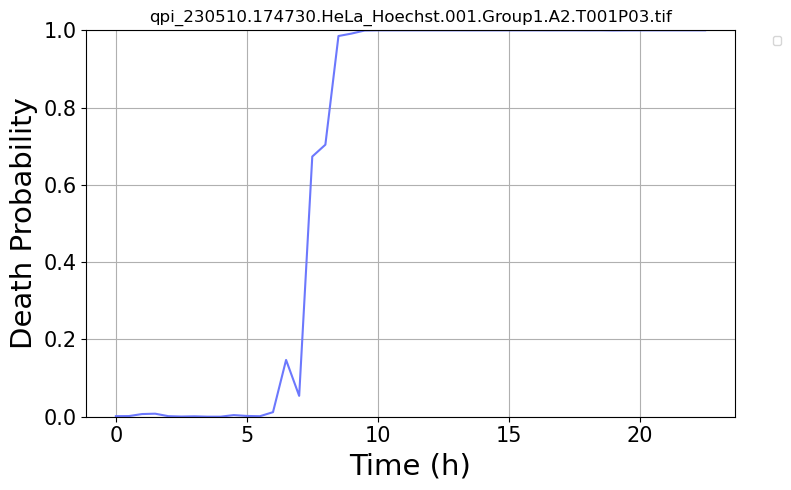

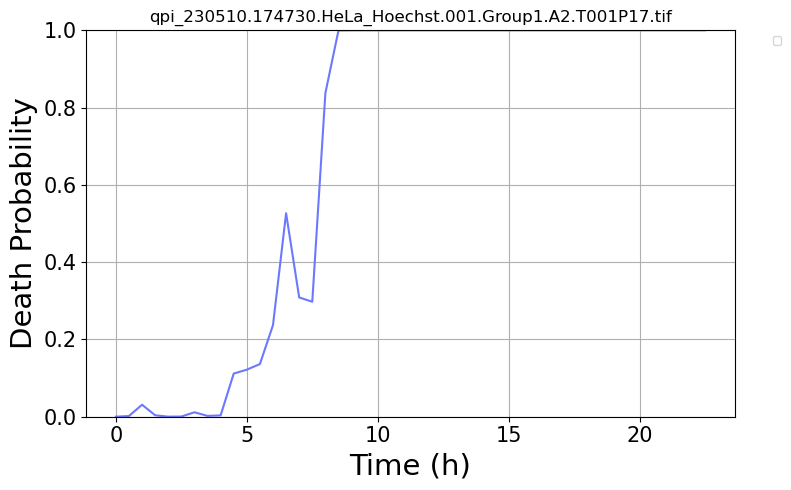

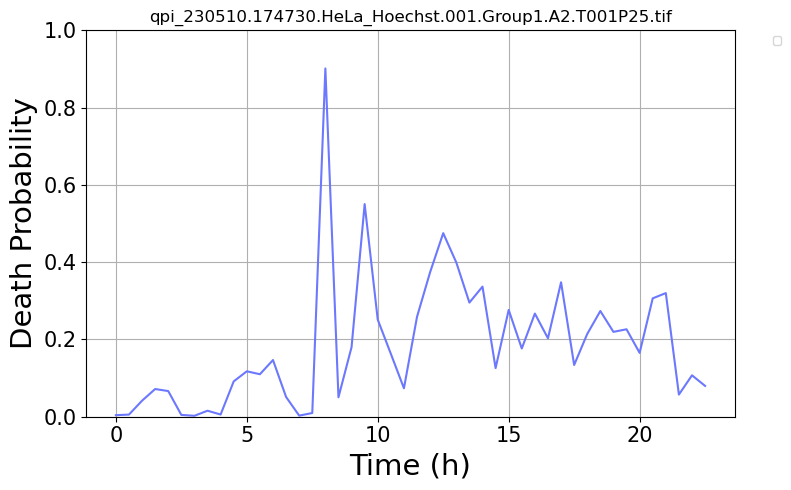

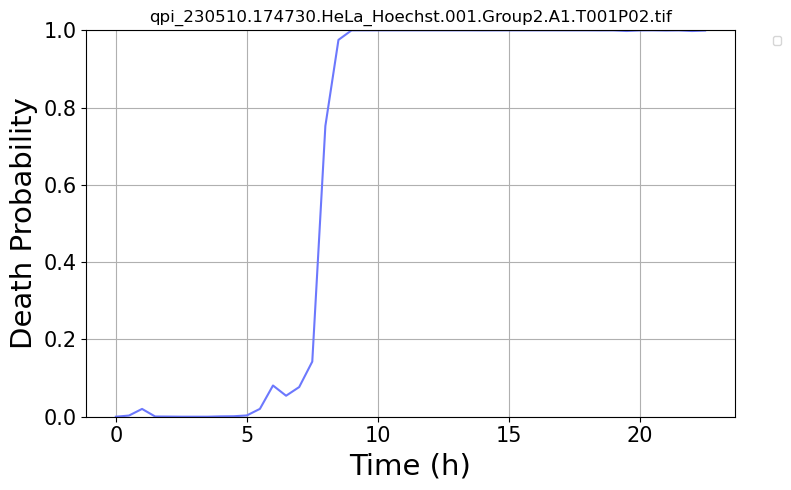

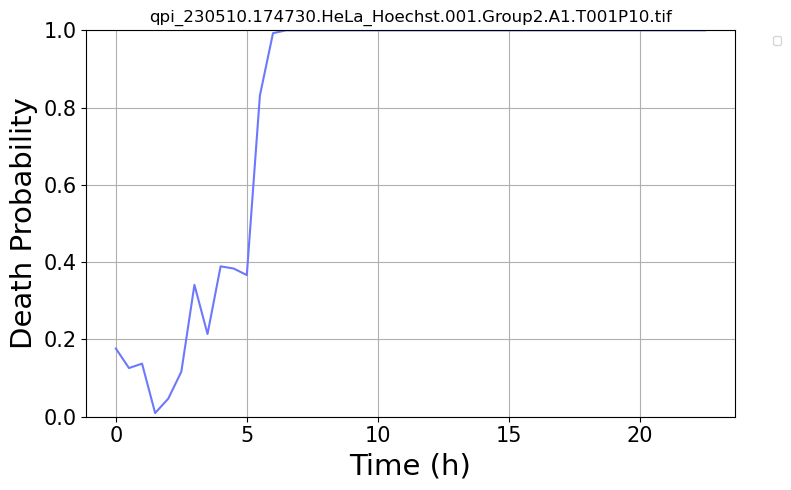

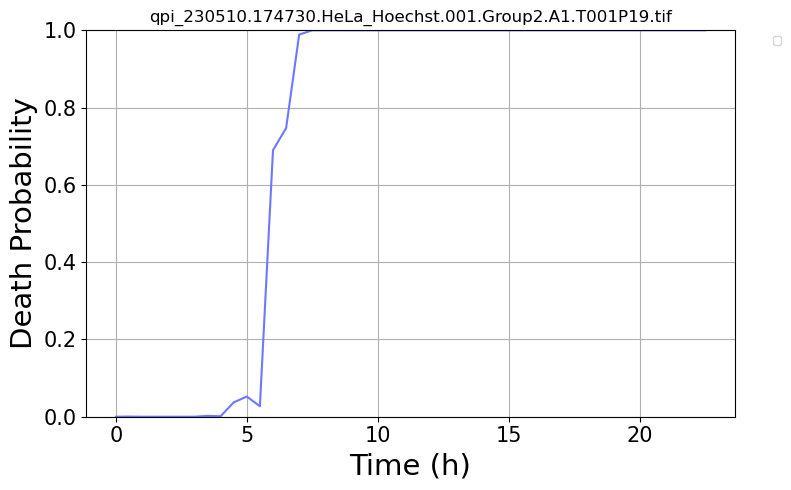

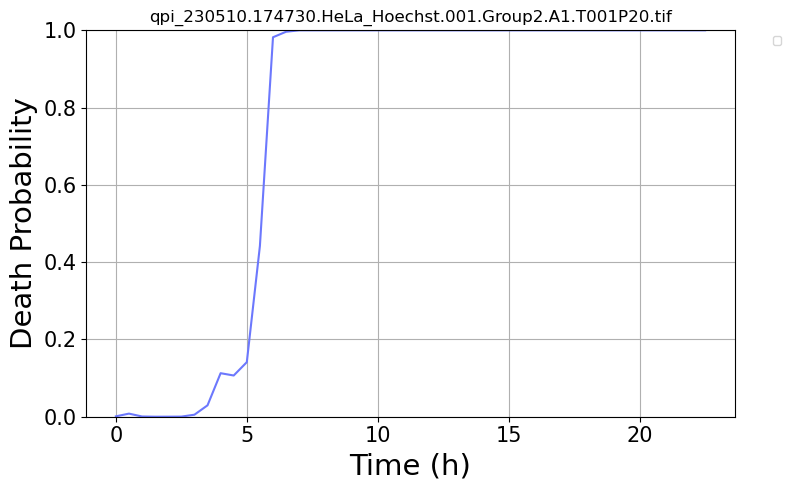

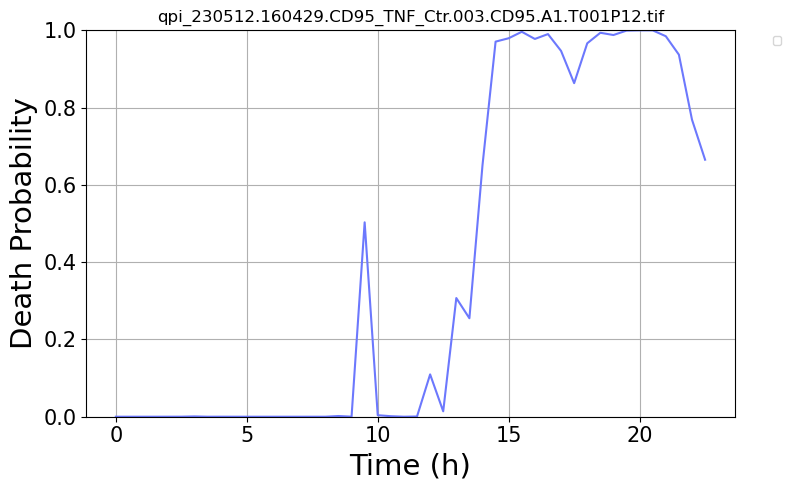

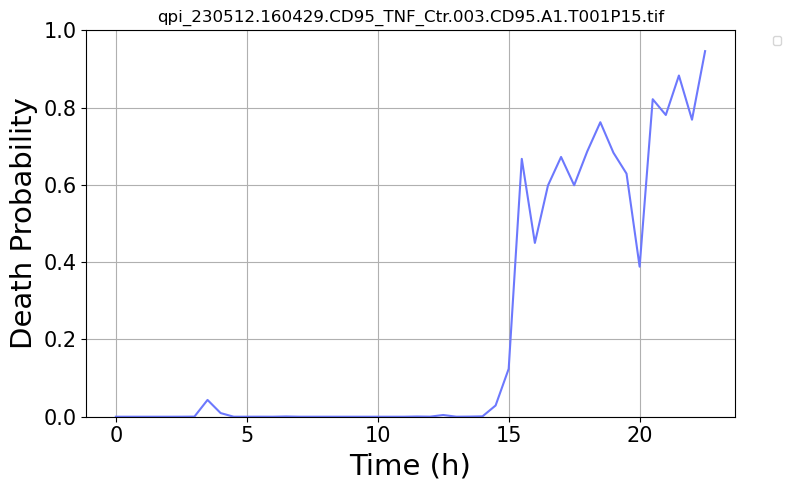

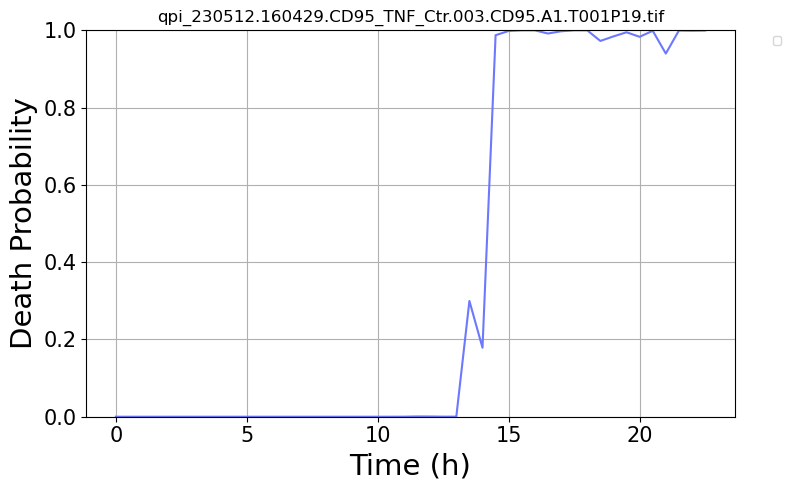

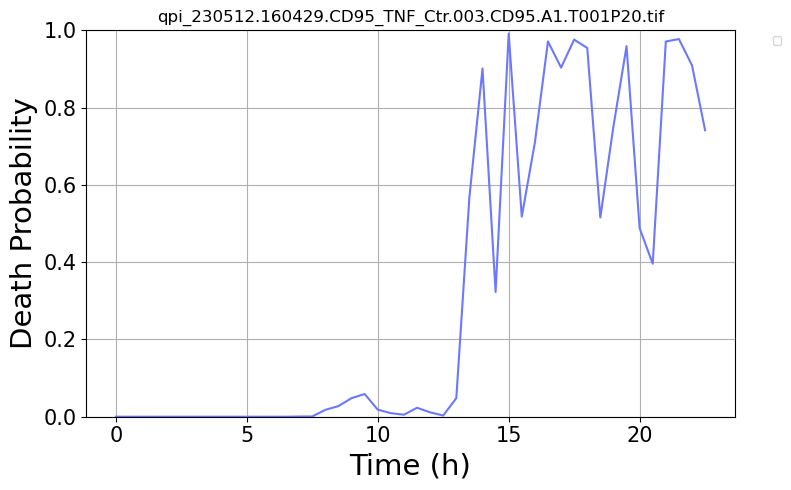

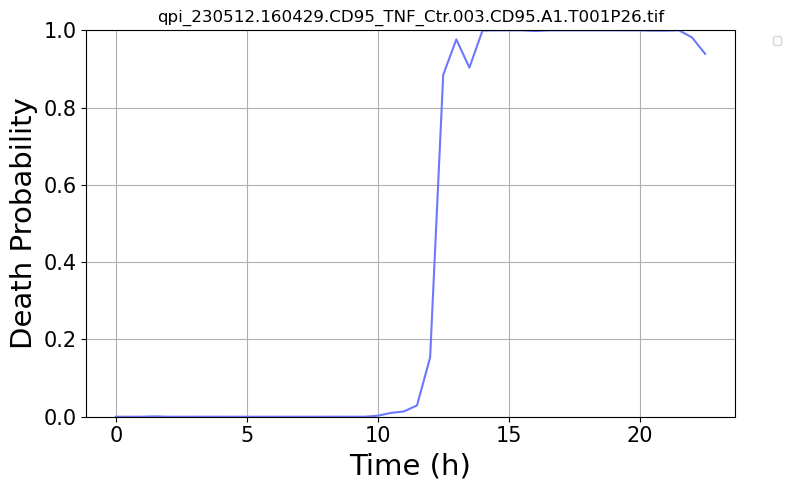

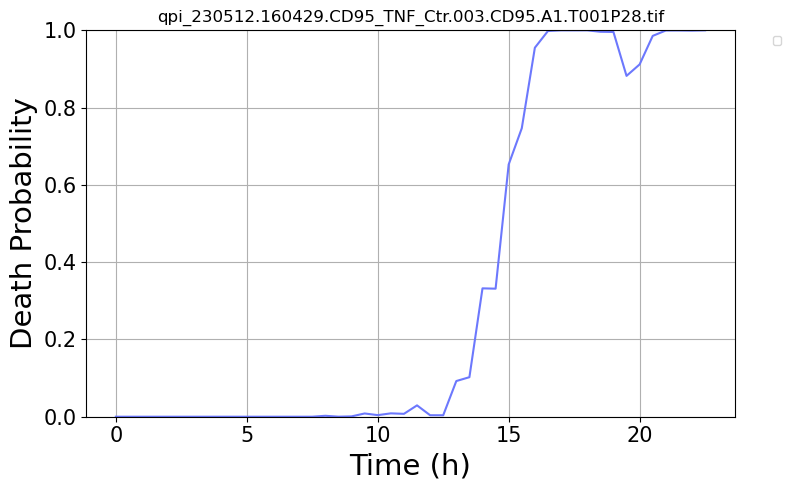

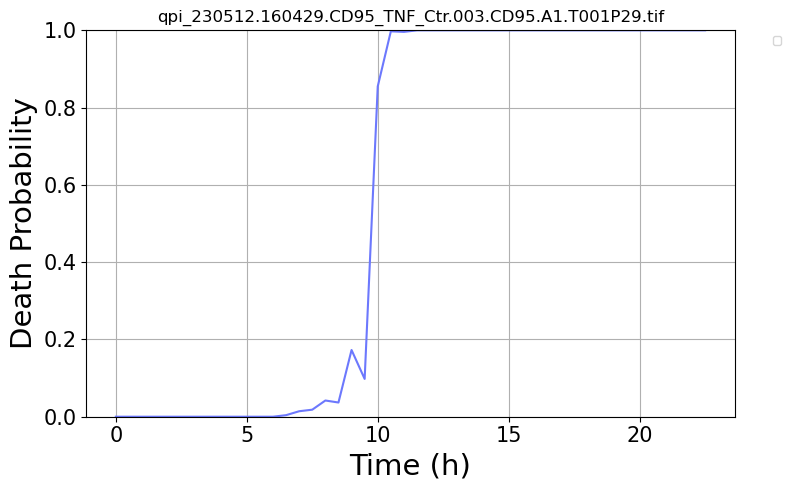

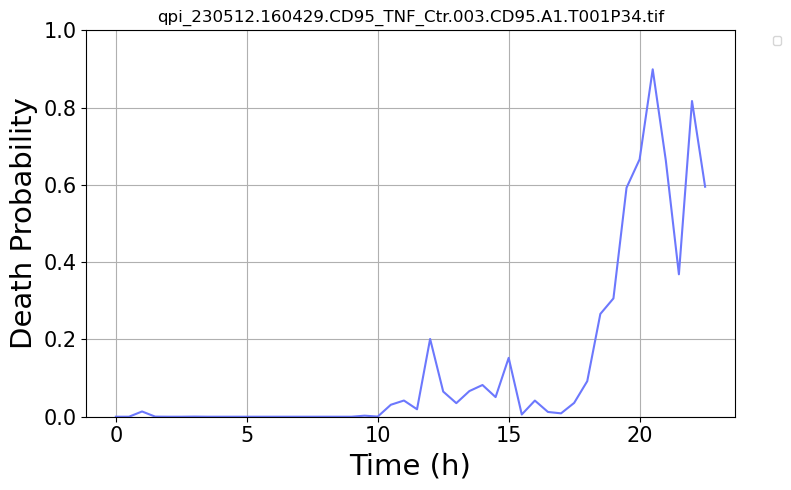

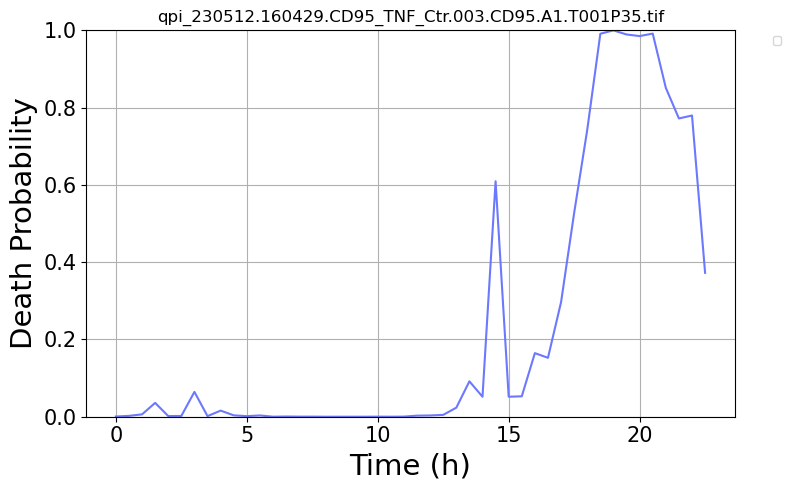

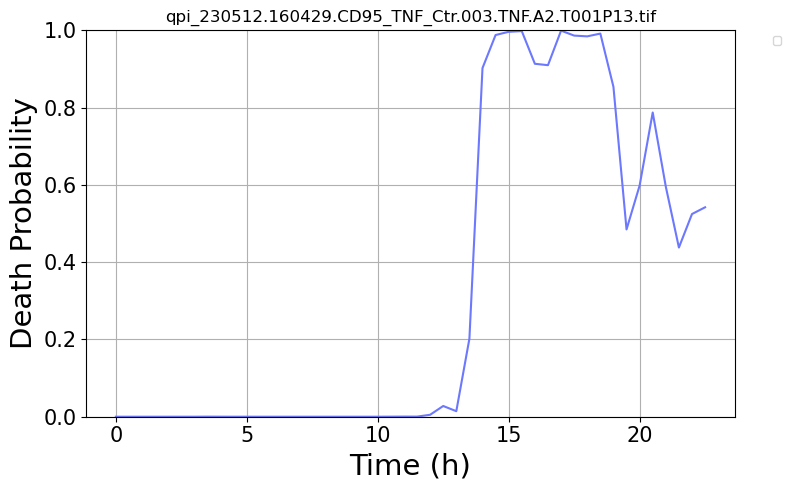

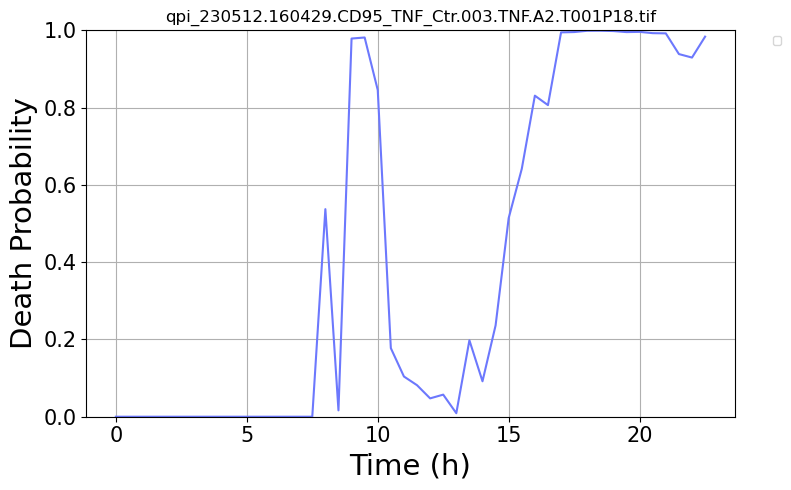

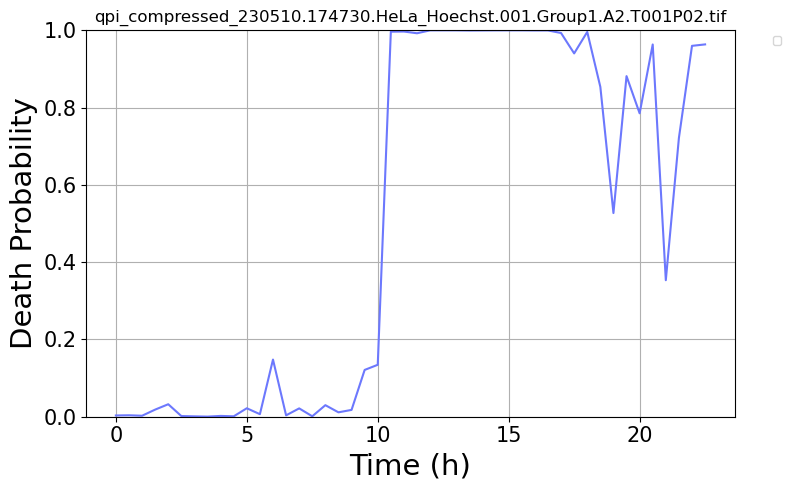

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot each file's probabilities over time
filename_list = []
probability_list = []
for filename, probabilities in all_probabilities.items():
    
    filename_list.append(filename)
    probability_list.append(probabilities)
    x = np.arange(len(probabilities)) * 0.5
    
    plt.figure(figsize=(8,5))
    plt.plot(x, probabilities, color='#6c78fd')
    # plt.title(f"Dead Probability Over Time for File {filename}")
    plt.title(f"{filename}")
    plt.xlabel("Time (h)", fontsize=21)
    plt.ylabel("Death Probability", fontsize=21)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Legend outside the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\김민욱\AppData\Local\Temp\ipykernel_8564\3099425217.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Legend outside the plot


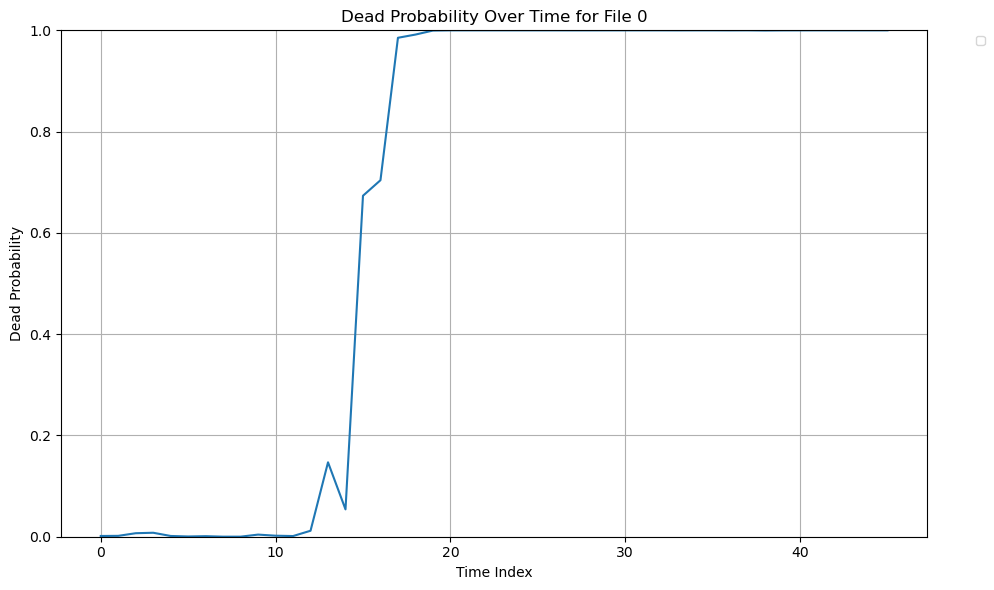

In [34]:
import matplotlib.pyplot as plt

idx = 0

plt.figure(figsize=(10,6))
plt.plot(probability_list[idx])
plt.title(f"Dead Probability Over Time for File {idx}")
plt.xlabel("Time Index")
plt.ylabel("Dead Probability")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Legend outside the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import napari
from TCFile import TCFile
viewer = napari.Viewer()

In [2]:
import numpy as np
file = r"C:\rkka_Projects\cell_death_v1\Data\before_preprocess\Hela_PWS\Hela_Segmentation_test_PWS\TCF\230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF"
tcf = TCFile(file, '2DMIP')
viewer.add_image(np.array([tcf[i] for i in range(len(tcf))]))

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"


<Image layer 'Image' at 0x258e1a0e840>